# Reflexion
Is an architecture designed to learn through verbal feedback and self-reflection. The agent explicitly critiques its reponses for tasks to generate a higher quality final response, at the expense of longer execution time.

In [14]:
from dotenv import load_dotenv
load_dotenv()

import re
import os
import json
import base64
import asyncio
import datetime
import platform
import requests
import operator
import playwright
import numpy as np
import pandas as pd
import datetime as dt

from enum import Enum
from typing import List
from typing import Dict
from typing import Tuple
from typing import Union
from typing import Literal
from typing import Optional
from typing import Sequence
from typing import Annotated
from typing import TypedDict
from operator import itemgetter
from collections import defaultdict

from IPython import display
from IPython.display import HTML
from IPython.display import Image

from langsmith import traceable

from langgraph.graph import END
from langgraph.graph import StateGraph
from langgraph.graph import MessageGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt.tool_executor import ToolInvocation

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from langchain_core.tools import StructuredTool
from langchain_core.messages import BaseMessage
from langchain_core.messages.ai import AIMessage
from langchain_core.messages.chat import ChatMessage
from langchain_core.messages.tool import ToolMessage
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.system import SystemMessage
from langchain_core.messages.function import FunctionMessage
from langchain_core.prompts.image import ImagePromptTemplate

from langchain_core.pydantic_v1 import Field
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import RunnableParallel
from langchain_core.pydantic_v1 import ValidationError
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

from langchain_core.runnables.graph import CurveStyle
from langchain_core.runnables.graph import NodeColors
from langchain_core.runnables.graph import MermaidDrawMethod

from langchain import hub
from langchain.schema import Document
from langchain.prompts import PromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain.prompts import MessagesPlaceholder
from langchain.prompts import HumanMessagePromptTemplate
from langchain.prompts import SystemMessagePromptTemplate
from langchain.agents import create_openai_functions_agent
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.output_parsers.openai_tools import JsonOutputToolsParser

from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

from langchain_fireworks.chat_models import ChatFireworks

In [2]:

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'Reflexion'

In [3]:
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

The tools are invoked _in context_. Create a function that invokes all the requested tools.

In [4]:
actor_prompt = '''You are an expert researcher. 
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.'''

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            actor_prompt
        ),
        MessagesPlaceholder(variable_name='messages'),
        (
            'user',
            '\n\n<reminder>Reflect on the user\'s original question and the actions taken thus far. Respond using the {function_name} function.</reminder>'
        )
    ]
).partial(time=lambda: datetime.datetime.now().isoformat())


class Reflection(BaseModel):
    missing: str = Field(description='Critique of what is missing')
    superfluous: str = Field(description='Critique of what is superfluous')


class AnswerQuestion(BaseModel):
    '''Answer the question'''
    answer: str = Field(description='~250 word detailed answer to the question.')
    reflection: Reflection = Field(description='Your reflection on the initial answer.')
    search_queries: List[str] = Field(description='1 - 3 search queries for researching improvements to address the critique of your current answer.')


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    @traceable
    def respond(self, state: List[BaseMessage]):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke({'messages': state}, {'tags': [f'attempt:{attempt}']})
            try:
                self.validator.invoke(response)
                return response
            except ValidationError as e:
                print('RETRYING', attempt)
                state = state + [
                    response,
                    ToolMessage(
                        content=f'{repr(e)}\n\nPay close attention to the function schema.\n\n'
                        + self.validator.schema_json()
                        + ' Respond by fixing all validation errors.',
                        tool_call_id=response.tool_calls[0]['id'],
                    )
                ]

        return response

In [5]:
llm = ChatOpenAI(model='gpt-4o')
initial_answer_chain = actor_prompt_template.partial(
    first_instruction='Provide a detailed ~250 word answer.',
    function_name=AnswerQuestion.__name__) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])
first_responder = ResponderWithRetries(runnable=initial_answer_chain, validator=validator)

In [6]:
example_question = 'Why is reflection useful in AI?'
initial = first_responder.respond([HumanMessage(content=example_question)])

RETRYING 0


In [9]:
JsonOutputToolsParser(return_id=True).invoke(initial)

[{'args': {'answer': "Reflection in AI refers to an AI system's ability to monitor, analyze, and adapt its own processes and performance. This capability is essential for several reasons. Firstly, it allows AI systems to improve over time. By reflecting on past actions and outcomes, an AI can identify errors, learn from them, and adjust its behavior to avoid making the same mistakes in the future. This is particularly important in dynamic environments where conditions and requirements may change rapidly. Secondly, reflection enhances the transparency and explainability of AI systems. By being able to articulate why certain decisions were made or why particular actions were taken, AI systems can provide insights into their decision-making processes. This can increase trust and acceptance among users and stakeholders. Thirdly, reflection can contribute to ethical AI development. It enables AI systems to assess the implications of their actions and ensure they align with ethical guideline

### Revision
The second part of the actor is a revision step

In [10]:
revise_instructions = '''Revise your previous answer using the new information. 
    - You should use the previous critique to add important information to your answer. 
        - You MUST include numerical citations in your revised answer to ensure it can be verified. 
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of: 
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.'''

# extend the initial answer schema to include references
# forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    '''Revise your original answer to the question. Provide an answer, reflection, cite your reflection with references and finally add search queries to improve the answer'''
    references: List[str] = Field(description='Citations motivating your updated answer')

revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])
revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [11]:
revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]['id'],
            content=json.dumps(
                tavily_tool.invoke(
                    {
                        'query': initial.tool_calls[0]['args']['search_queries'][0]
                    }
                )
            )
        )
    ]
)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a7zHIQgGQSPiCwAU8PE7Dz8E', 'function': {'arguments': '{"answer": "Reflection in AI refers to an AI system\'s ability to monitor, analyze, and adapt its own processes and performance. This capability is essential for several reasons. Firstly, it allows AI systems to improve over time. By reflecting on past actions and outcomes, an AI can identify errors, learn from them, and adjust its behavior to avoid making the same mistakes in the future. This is particularly important in dynamic environments where conditions and requirements may change rapidly. Secondly, reflection enhances the transparency and explainability of AI systems. By being able to articulate why certain decisions were made or why particular actions were taken, AI systems can provide insights into their decision-making processes. This can increase trust and acceptance among users and stakeholders. Thirdly, reflection can contribute to ethical AI developme

In [12]:
JsonOutputToolsParser().invoke(revised)

[{'args': {'answer': "Reflection in AI refers to an AI system's ability to monitor, analyze, and adapt its own processes and performance. This capability is essential for several reasons. Firstly, it allows AI systems to improve over time. By reflecting on past actions and outcomes, an AI can identify errors, learn from them, and adjust its behavior to avoid making the same mistakes in the future. This is particularly important in dynamic environments where conditions and requirements may change rapidly. Secondly, reflection enhances the transparency and explainability of AI systems. By being able to articulate why certain decisions were made or why particular actions were taken, AI systems can provide insights into their decision-making processes. This can increase trust and acceptance among users and stakeholders. Thirdly, reflection can contribute to ethical AI development. It enables AI systems to assess the implications of their actions and ensure they align with ethical guideline

## Create Tool Node
Next, create a node to execute the tool calls. While we give the LLMs different schema names (and use those for validation), we want them both to route to the same tool

In [15]:
def run_queries(search_queries: list[str], **kwargs):
    '''Run the generated queries'''
    return tavily_tool.batch([{'query': query} for query in search_queries])

tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__)
    ]
)

## Construct Graph

In [16]:
MAX_ITERATIONS = 5
builder = MessageGraph()
builder.add_node('draft', first_responder.respond)
builder.add_node('execute_tools', tool_node)
builder.add_node('revise', revisor.respond)

builder.add_edge('draft', 'execute_tools') # draft -> execute_tools
builder.add_edge('execute_tools', 'revise') # execute_tools -> revise

In [17]:
# explicit loop
def _get_num_iterations(state: List[BaseMessage]):
    i = 0
    for m in state[::-1]:
        if m.type not in {'tool', 'ai'}:
            break
        i += 1
    return i

def event_loop(state: List[BaseMessage]) -> Literal['execute_tools', '__end__']:
    # in our case we'll just stop after N plans
    if _get_num_iterations(state) > MAX_ITERATIONS:
        return END
    return 'execute_tools'

# revise -> execute_tools OR end
builder.add_conditional_edges('revise', event_loop)
builder.set_entry_point('draft')
graph = builder.compile()

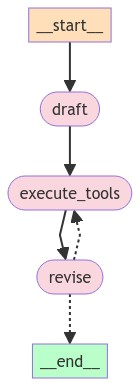

In [19]:
display.display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
events = graph.stream(
    [HumanMessage(content='How should we handle the climate crisis?')],
    stream_mode='values'
)

for i, step in enumerate(events):
    print(f'Step {i}')
    step[-1].pretty_print()

Step 0
================================ Human Message =================================

How should we handle the climate crisis?
RETRYING 0
RETRYING 1
RETRYING 2
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_IJ82yHQTFFnwSt4SXuYhs7cN)
 Call ID: call_IJ82yHQTFFnwSt4SXuYhs7cN
  Args:
    answer: Addressing the climate crisis requires a multi-faceted approach that involves global cooperation, ambitious policy-making, technological innovation, and significant shifts in individual and collective behavior. Here are some key strategies to handle the climate crisis effectively:

1. **International Cooperation**: Climate change is a global issue that requires coordinated international efforts. Agreements like the Paris Accord are critical, where countries commit to reducing greenhouse gas emissions and share technologies and strategies.

2. **Policy and Regulation**: Governments need to implement stringent policies to 

ValidationError: 1 validation error for AnswerQuestionSchema
search_queries
  field required (type=value_error.missing)

### Observations
Observations to consider when adapting a workflow

1. This agent trades off execution time for quality. It explicitly forces the agent to critique and revise the output over several steps, which usually (not always) increases the response quality but takes much longer to return a final answer.
2. The 'reflections' can be paired with additional external feedback (such as validators), to further guide the actor.
3. In the paper, 1 environment (AlfWorld) uses external memory. It does this by storing summaries of the reflections to an external store and using them in subsequent trials/invocations